In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanishqkakkar","key":"8be579d49f668f4c35063916511ae8c6"}'}

In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle

In [ ]:
import pandas as pd
import os
import opendatasets as od

In [ ]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data'
# Using opendatasets let's download the data sets
od.download(dataset)

100%|██████████| 28.7G/28.7G [04:51<00:00, 106MB/s]



Extracting archive ./h-and-m-personalized-fashion-recommendations/h-and-m-personalized-fashion-recommendations.zip to ./h-and-m-personalized-fashion-recommendations


In [ ]:
pip install transformers

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 7.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 880.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 962.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
import torch

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU!")
else:
    device = "cpu"
    print("Using CPU!")

Using CPU!


In [ ]:
# Load the dataset
df = pd.read_csv("/content/hnm_dataset/articles.csv")

df['detail_desc'].fillna('', inplace=True)
df['combined_text'] = df['prod_name'] + ' ' + df['product_type_name'] + ' ' + df['product_group_name'] + ' ' + df['department_name'] + ' ' + df['index_group_name'] + ' ' + df['colour_group_name'] + ' ' + df['detail_desc']

# Load the sentence-transformer model (using MiniLM for efficiency)
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to GPU

# Precompute product embeddings (do this once)
product_texts = df['combined_text'].tolist()

batch_size = 1000  # Adjust this based on your memory limitations
product_embeddings = []
for i in range(0, len(product_texts), batch_size):
    batch_texts = product_texts[i:i+batch_size]
    batch_embeddings = model.encode(batch_texts, convert_to_tensor=True)
    product_embeddings.append(batch_embeddings)

product_embeddings = torch.cat(product_embeddings, dim=0)

disliked_items = set()

def get_top_recommendations(query, top_k=5, exclude_indices=[]):
    # Encode the query using the loaded model
    query_embedding = model.encode(query, convert_to_tensor=True).to(device)

    # Compute cosine similarities between query and product embeddings
    similarities = util.pytorch_cos_sim(query_embedding, product_embeddings)[0]

    # Extract top_k + len(exclude_indices) products with the highest similarities
    top_indices = torch.topk(similarities, k=top_k + len(exclude_indices)).indices.cpu().numpy()

    # Filter out the excluded items from the recommendations
    top_indices = [idx for idx in top_indices if idx not in exclude_indices][:top_k]
    top_products = df.iloc[top_indices]

    return top_products

def display_image(article_id, prod_name, ax):
    article_id_str = str(article_id)
    subfolder = '0' + article_id_str[:2]
    picture_name = '0' + article_id_str
    path = f'/content/hnm_dataset/images/{subfolder}/{picture_name}.jpg'

    if os.path.exists(path):
        img = plt.imread(path)
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.imshow(np.zeros((200, 200, 3)))
        ax.axis('off')

def get_closest_match(name, top_matches):
    # Encode the name using the model
    name_embedding = model.encode(name, convert_to_tensor=True).to(device)

    # Extract names of top matches for similarity computation
    top_names = top_matches['prod_name'].tolist()
    top_name_embeddings = model.encode(top_names, convert_to_tensor=True).to(device)

    # Compute similarities
    similarities = util.pytorch_cos_sim(name_embedding, top_name_embeddings)[0]

    # Get the index of the top match
    top_index = torch.argmax(similarities).item()

    return top_matches.iloc[top_index]['article_id']

In [ ]:
model_name = "gpt2-medium"  # You can adjust the model size as per your computational capacity
gpt_model = GPT2LMHeadModel.from_pretrained(model_name)
gpt_tokenizer = GPT2Tokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def generate_fashion_suggestion(prompt, max_length=100):
    """Generate a fashion suggestion using GPT model."""

    input_ids = gpt_tokenizer.encode(prompt, return_tensors="pt")
    output = gpt_model.generate(input_ids, max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2)
    generated_text = gpt_tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract the suggestion from the generated text
    suggestion = generated_text[len(prompt):]
    return suggestion.strip()

In [ ]:
def fashion_bot():
    print("Welcome to the fashion recommendation bot! Ask me for outfit suggestions.")
    while True:
        user_query = input("\nYou: ")
        if user_query.lower() in ["quit", "exit"]:
            print("Fashion bot: Goodbye!")
            break

        exclude_indices = []  # To hold indices of disliked items in a session
        top_matches = get_top_recommendations(user_query)

        # Use GPT model to generate fashion advice
        prompt = f"Suggest an outfit based on: '{user_query}'"
        suggestion = generate_fashion_suggestion(prompt)
        print(f"\nFashion bot: {suggestion}")
        # Show initial recommendations
        print("\nFashion bot: Here are some suggestions from our wadrobe:\n")
        fig, axes = plt.subplots(1, len(top_matches), figsize=(15, 5))
        for i, (index, row) in enumerate(top_matches.iterrows()):
            display_image(row['article_id'], row['prod_name'], axes[i])
        plt.tight_layout()
        plt.show()
        time.sleep(2)

        while True:
            feedback = input("Would you like to provide feedback on the items? (yes/no) ")
            if feedback.lower() != 'yes':
                break

            disliked_name = input("Type the name of the item you dislike: ")
            closest_match_idx = df.index[df['prod_name'].str.contains(disliked_name, case=False)].tolist()[0]
            exclude_indices.append(closest_match_idx)

            # Fetch new recommendations excluding disliked items
            top_matches = get_top_recommendations(user_query, top_k=5, exclude_indices=exclude_indices)

            # Display the new recommendations
            print("\nFashion bot: Here are new suggestions based on your feedback:\n")
            fig, axes = plt.subplots(1, len(top_matches), figsize=(15, 5))
            for i, (index, row) in enumerate(top_matches.iterrows()):
                display_image(row['article_id'], row['prod_name'], axes[i])
            plt.tight_layout()
            plt.show()
            time.sleep(2)

Welcome to the fashion recommendation bot! Ask me for outfit suggestions.

You: I want a format suit for office meetings.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


     article_id  product_code                  prod_name  product_type_no  \
445   241602023        241602  Manson SF slim fit blazer              264   
444   241602018        241602  Manson SF slim fit blazer              264   
447   241602027        241602  Manson SF slim fit blazer              264   
448   241602028        241602  Manson SF slim fit blazer              264   
446   241602024        241602  Manson SF slim fit blazer              264   

    product_type_name  product_group_name  graphical_appearance_no  \
445            Blazer  Garment Upper body                  1010010   
444            Blazer  Garment Upper body                  1010010   
447            Blazer  Garment Upper body                  1010026   
448            Blazer  Garment Upper body                  1010016   
446            Blazer  Garment Upper body                  1010010   

    graphical_appearance_name  colour_group_code colour_group_name  ...  \
445                   Melange            

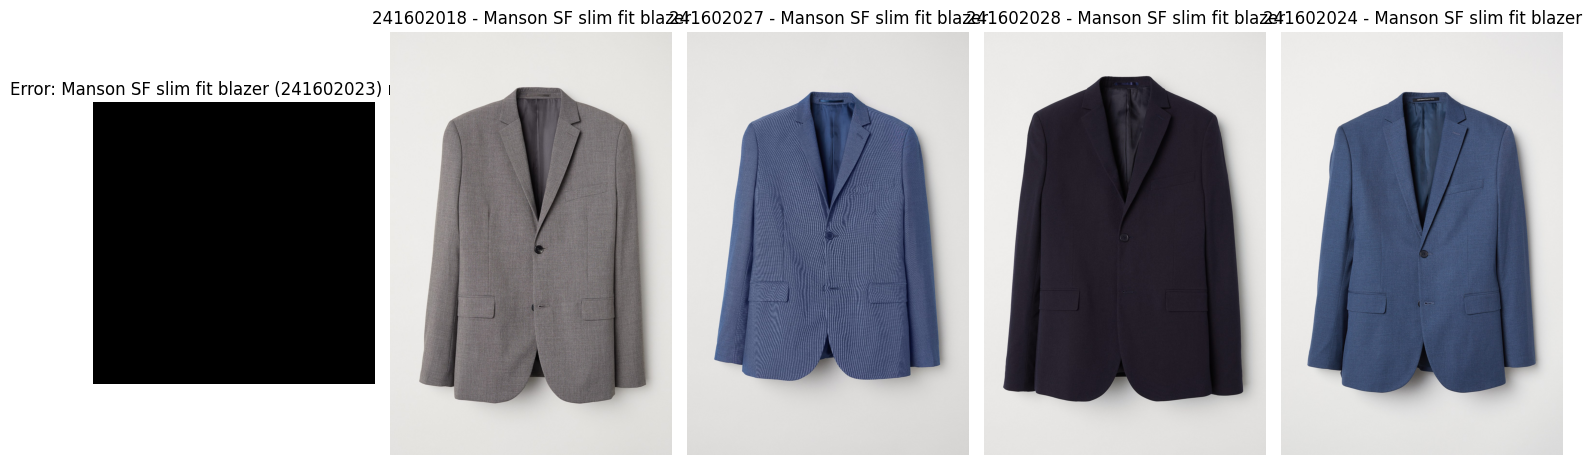

Would you like to provide feedback on the items? (yes/no) yes
Type the name of the item you dislike: Manson SF slim fit blazer

Fashion bot: Here are new suggestions based on your feedback:



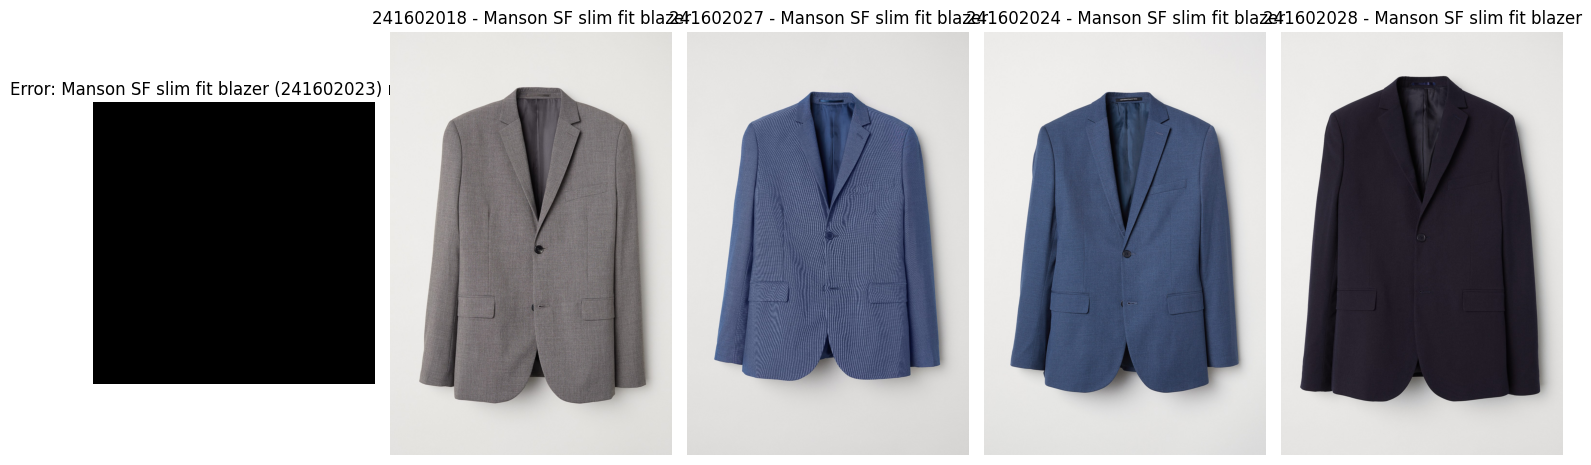

Would you like to provide feedback on the items? (yes/no) yes
Type the name of the item you dislike: 241602018


IndexError: list index out of range

In [ ]:
fashion_bot()

In [ ]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.6 MB/s eta 0:00:00


In [ ]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("Revanthraja/Fashion")

# Define your text prompt
prompt = "a photorealistic portrait of a cat wearing a top hat"

# Generate the image using the pipeline
image = pipeline(prompt).images[0]

# Save the generated image (replace 'output.png' with your desired filename)
image.save("output.png")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]